# Predictive Modeling for Library Migration

## Hypothesis

* H1: If many other projects have removed a library, it will be more likely for a project to migrate away from this library
* H2: If many other projects have migrated from a library, it will be more likely for a project to migrate away from this library
* H3: If the use of a library do not align well with current best practices, it will more likely for a project to migrate away from this library
* H4: If a project have simultaneous use of same-domain libraries, it will be more likely to consolidate its usage to a single library
* H5: A project is more likely to use a library that its upstream projects are already using
* H6: If a library is not actively maintained, it will be more likely for a project to migrate away from this library
* H7: If a library has unpatched security vulnerabilities, it will be more likely for a project to migrate away from this library
* H8: If a library has an unusual license, it will be more likely for a project to migrate away from this library

## Model

首先，我们确立一组感兴趣的库集合$L$（$L$可能是若干个同一领域的库）。我们对这些库在大规模的项目集合$\mathcal{P}$上提取所有的依赖项变更

$$
\begin{align}
\Delta L   &= \{\langle t,p,c,f,l^-,l^+,v^-,v^+ \rangle\}, p\in \mathcal{P}, x \in \Delta L \Rightarrow x.l^- \in L \lor x.l^+ \in L\\
\Delta L^+ &= \{x | x \in \Delta L \land x.l^+ \in L \land x.l^- = \emptyset \}\\
\Delta L^- &= \{x | x \in \Delta L \land x.l^- \in L \land x.l^+ = \emptyset\}
\end{align}
$$

其中，$t$是时间，$c$是Commit，$f$是被修改的依赖配置文件。

我们使用逻辑回归模型来拟合一个函数$f$，满足

$$
\begin{cases}
f(x) = 1, x \in \Delta L^+ \\
f(x) = 0, x \in \Delta L^-
\end{cases}
$$

对每个$x \in \Delta L$，定义其被添加或被删除的库为$l$，计算如下特征

1. 项目做出变更的时间$t$减去$l$最近的上一次发布的时间。（刻画库是否正在被维护，验证H6）
2. 项目做出变更的时间$t$减去$l$的第一次发布的时间。（刻画库的老旧程度，验证H6）
3. 项目做出变更时，$l$能够查询到的安全漏洞的数量。（刻画库的安全漏洞情况，验证H7）
4. $l$的许可证情况，按$L$集合里的许可证数量进行one-hot encoding。（验证H8）
5. 项目做出变更时，项目的间接依赖里是否已经包含$l$。（验证H5）
6. 项目做出变更时，项目的其他依赖配置文件里是否已经声明了$l$。(验证H4）
7. 项目做出变更时，$l$在$\mathcal{P}$中的全局留存率（1 - 被删除的次数 / 被添加的次数）。（验证H1）
8. 项目做出变更时，$l$在已确认迁移中的流入比率（迁移图上入度 / 出度）。（验证H2）
9. 项目做出变更时，$l$与剩下所有依赖的Pointwise Mutual Information (PMI)均值
    $$
    \frac{1}{|x.f|}\sum_{l'\in x.f} \log \frac{p(l,l')}{p(l)p(l')}
    $$
    公式中概率使用$\mathcal{P}$中所有依赖配置文件来估计。（验证H3）

备注：为了计算上述指标，需要额外研究一下如何获取安全漏洞数据。可能考虑：GitHub Advisories，或参考已有研究。

In [1]:
from datetime import datetime
import pymongo
import pytz
import pandas as pd
from dateutil.parser import parse as dateParser
import datautil
import re
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Set
import csv
import multiprocessing
from itertools import repeat
from pathos.pools import ProcessPool
import time
from tqdm import tqdm
MONGO_URL = "mongodb://127.0.0.1:27017"
db = pymongo.MongoClient(MONGO_URL, connect=False, maxPoolSize=200).migration_helper
raw_db = pymongo.MongoClient(MONGO_URL, connect=False, maxPoolSize=200).libraries
migration_commits = pd.read_csv('data/migration_changes_with_time.csv', dtype=object)
migration_commits_values = migration_commits.values
count = 0

def get_migration_to_library(lib: str) -> pd.DataFrame:
    # migration_commits = pd.read_csv('data/migration_changes.csv', dtype=object)
    lib_required = migration_commits['lib2'].map(lambda x: x == lib)
    type_required = migration_commits['type'].map(lambda x: x == 'add')
    migration_to_commits = migration_commits[lib_required & type_required]
    return migration_to_commits

def get_migration_to_library_before(lib: str, datetime: datetime) -> pd.DataFrame:
    # migration_commits = pd.read_csv('data/migration_changes_with_time.csv', dtype=object)
    datetime = str(datetime)
    migration_to_commits_before = migration_commits_values[(migration_commits_values[:, -1] < str(datetime)) & (migration_commits_values[:, 5] == lib) &( migration_commits_values[:, 3] == 'add')]
    return len(migration_to_commits_before)

def get_migration_to()->np.ndarray:
    type_required = migration_commits['type'].map(lambda x: x == 'add')
    migration_to_commits = migration_commits[type_required]
    return migration_to_commits

def get_migration_from()->np.ndarray:
    type_required = migration_commits['type'].map(lambda x: x == 'rem')
    migration_from_commits = migration_commits[type_required]
    return migration_from_commits

def get_migration_from_library(lib: str) -> pd.DataFrame:
    type_required = migration_commits['type'].map(lambda x: x == 'rem')
    lib_required = migration_commits['lib1'].map(lambda x: x == lib)
    migration_from_commits = migration_commits[lib_required & type_required]
    return migration_from_commits

def get_migration_from_library_before(lib: str, datetime: datetime) -> pd.DataFrame:
    datetime = str(datetime)
    migration_from_commits_before = migration_commits_values[(migration_commits_values[:, -1] < str(datetime)) & (migration_commits_values[:, 4] == lib) &( migration_commits_values[:, 3] == 'rem')]
    return len(migration_from_commits_before)


def get_commit_time(commit: str) -> datetime:
    c = db.wocCommit.find_one({"_id": commit})
    if c is not None:
        return c['timestamp'].replace(tzinfo=pytz.timezone('UTC'))

    else:
        return None


def get_library_nearest_published_time(lib: str, commit_time: datetime) -> datetime:
    raw_dbt = pymongo.MongoClient(MONGO_URL, connect=False, maxPoolSize=None).libraries
    library_versions = list(raw_dbt.versions.find({"Platform": "Maven", "Project Name": lib}, sort=[
                                            ("Published Timestamp", pymongo.DESCENDING)]))
    for library_version in library_versions:
        published_time = dateParser(library_version['Published Timestamp'])
        if published_time < commit_time:
            return published_time
    return None


def get_library_first_published_time(lib: str) -> datetime:
    return dateParser(list(raw_db.versions.find({"Platform": "Maven", "Project Name": lib}, sort=[
        ("Published Timestamp", pymongo.ASCENDING)]))[0]["Published Timestamp"])


def get_project_before_config_direct_dependency(commit: str, config_filename: str) -> List:
    diffs = db.wocCommit.find_one({"_id": commit})['diffs']
    pom_blob = None
    for diff in diffs:
        if diff['filename'] == config_filename:
            pom_blob = diff['oldBlob']
    if not pom_blob:
        return None
    else:
        direct_dependencies = db.wocPomBlob.find_one({'_id': pom_blob})['dependencies']
        return direct_dependencies


def get_project_before_other_direct_dependency(project: str, commit: str, config_filename: str) -> pd.DataFrame:
    commits = db.wocRepository.find_one({"name": project.replace("/", "_")})['commits']
    migration_time = get_commit_time(commit)
    other_config_blobs = {}
    dependencies = []
    print(len(commits))
    i = 0
    for c in commits:
        if (i % 100 == 0):
            print(i)
        i += 1
        commit = db.wocCommit.find_one({"_id": c})
        if commit is None:
            continue
        commit_time = commit['timestamp'].replace(tzinfo=pytz.timezone('UTC'))
        if commit_time < migration_time:
            diffs = commit['diffs']
            for diff in diffs:
                if re.search(r'pom.xml', diff['filename']) is not None and config_filename != diff['filename']:
                    other_config_file = diff['filename']
                    if diff['filename'] not in other_config_blobs.keys():
                        other_config_blobs[other_config_file] = {"timestamp": commit_time, "blob": diff['newBlob']}
                    else:
                        if commit_time > other_config_blobs[other_config_file]['timestamp']:
                            other_config_blobs[other_config_file]['timestamp'] = commit_time
                            other_config_blobs[other_config_file]['blob'] = diff['newBlob']
    for value in other_config_blobs.values():
        if value['blob'] != "":
            dependencies.extend(db.wocPomBlob.find_one({'_id': value['blob']})['dependencies'])
    return pd.DataFrame(dependencies)


def get_library_direct_dependency(groupId: str, artifactId: str, version: str) -> List[dict]:
    dependencies = []
    projectName = groupId + ":" + artifactId
    if version != "" and '$' not in version and '[' not in version:
        results = list(db.lioProjectDependency.find(
            {"projectName": projectName, "versionNumber": {'$regex' :f"{version}.*"}}, sort=[
                ("version", pymongo.DESCENDING)]))        
    else:
        results = list(db.lioProjectDependency.find(
            {"projectName": projectName}, sort=[
                ("version", pymongo.DESCENDING)]))
    if results:
        versionNumber = results[0]['versionNumber']
        results = list(db.libraryVersionToDependency.find(
                {"projectName": projectName, "versionNumber": versionNumber}))
        for result in results:
            groupId, artifactId = result["projectName"].split(":")
            version = result["versionNumber"]
            dependencies.append({"groupId":groupId,"artifactId":artifactId, "version":version})
    return dependencies
    


def get_project_before_config_all_dependencies(commit: str, config_filename: str) -> pd.DataFrame:
    dependencies = []
    temp_dependencies = get_project_before_config_direct_dependency(commit, config_filename)
    while temp_dependencies:
        now_dependency = temp_dependencies.pop(0)
        if now_dependency in dependencies:
            continue
        else:
            dependencies.append(now_dependency)
        new_dependencies = get_library_direct_dependency(
            now_dependency['groupId'], now_dependency['artifactId'], now_dependency['version'])
        if new_dependencies:
            temp_dependencies.extend(new_dependencies)
            for d in new_dependencies:
                if d not in dependencies:
                    dependencies.append(d)
    return pd.DataFrame(dependencies)


def index_1(migration_change:np.ndarray, lib: str) -> int:
    change_time = dateParser(migration_change[-1])
    library_nearest_time = get_library_nearest_published_time(lib, change_time)
    if library_nearest_time:
        return (change_time - library_nearest_time).days
    else:
        return np.nan


def index_2(migration_change: np.ndarray, lib: str) -> int:
    change_time = dateParser(migration_change[-1])
    library_first_time = get_library_first_published_time(lib)
    return (change_time - library_first_time).days

def index_1_all(migration_change:np.ndarray) -> int:
    if migration_change[3] == 'add':
        lib = migration_change[5]
    elif migration_change[4] == 'rem':
        lib = migration_change[4]
    else:
        return np.nan
    change_time = dateParser(migration_change[-1])
    library_nearest_time = get_library_nearest_published_time(lib, change_time)
    if library_nearest_time:
        return (change_time - library_nearest_time).days
    else:
        return np.nan


def index_2_all(migration_change: np.ndarray) -> int:
    if migration_change[3] == 'add':
        lib = migration_change[5]
    elif migration_change[4] == 'rem':
        lib = migration_change[4]
    else:
        return np.nan
    change_time = dateParser(migration_change[-1])
    library_first_time = get_library_first_published_time(lib)
    return (change_time - library_first_time).days


def index_5(migration_change: np.ndarray, lib: str) -> int:
    groupId, artifactId = lib.split(':')
    all_dependencies = get_project_before_config_all_dependencies(
        migration_change[2], migration_change[3])
    if len(all_dependencies) == 0 or len(all_dependencies[(all_dependencies['groupId'] == groupId) & (all_dependencies['artifactId'] == artifactId)].index) == 0:
        return 0
    else:
        return 1


def index_6(migration_change: np.ndarray, lib: str) -> int:
    groupId, artifactId = lib.split(':')
    other_direct_dependencies = get_project_before_other_direct_dependency(migration_change[1],
        migration_change[2], migration_change[3])
    if len(other_direct_dependencies[(other_direct_dependencies['groupId'] == groupId) & (other_direct_dependencies['artifactId'] == artifactId)].index) == 0:
        return 0
    else:
        return 1


def get_library_retention_rate(migration_change:np.ndarray, lib: str) -> float:  # 7
    # commit_time = get_commit_time(migration_change[2])
    commit_time = migration_change[-1]
    remove = get_migration_from_library_before(lib, commit_time)
    add = get_migration_to_library_before(lib, commit_time)
#     if add == 0:
#         return float("-inf")
#     return 1 - remove / add
    if add == 0 and remove == 0:
        return 0
    return add / (add + remove)


def get_library_inflow_rate(migration_change:np.ndarray, lib: str) -> float:  # 8
    dbt = pymongo.MongoClient(MONGO_URL, connect=False, maxPoolSize=200).migration_helper
    commit_time = dateParser(migration_change[-1])
    add = len(list(dbt.wocConfirmedMigration.find(
        {"toLib": lib, "startCommitTime": {'$lt': commit_time}})))
    remove = len(list(dbt.wocConfirmedMigration.find(
        {"fromLib": lib, "startCommitTime": {'$lt': commit_time}})))
    if add == 0 and remove == 0:
        return 0
    return (add - remove) / (add + remove)

def get_library_retention_rate_all(migration_change:np.ndarray) -> float:  # 7
    if migration_change[3] == 'add':
        lib = migration_change[5]
    elif migration_change[4] == 'rem':
        lib = migration_change[4]
    else:
        return np.nan
    commit_time = migration_change[-1]
    remove = get_migration_from_library_before(lib, commit_time)
    add = get_migration_to_library_before(lib, commit_time)
#     if add == 0:
#         return float("-inf")
#     return 1 - remove / add
    if add == 0 and remove == 0:
        return 0
    return add / (add + remove)


def get_library_inflow_rate_all(migration_change:np.ndarray) -> float:  # 8
    dbt = pymongo.MongoClient(MONGO_URL, connect=False, maxPoolSize=None).migration_helper
    if migration_change[3] == 'add':
        lib = migration_change[5]
    elif migration_change[4] == 'rem':
        lib = migration_change[4]
    else:
        return np.nan
    commit_time = dateParser(migration_change[-1])
    add = len(list(dbt.wocConfirmedMigration.find(
        {"toLib": lib, "startCommitTime": {'$lt': commit_time}})))
    remove = len(list(dbt.wocConfirmedMigration.find(
        {"fromLib": lib, "startCommitTime": {'$lt': commit_time}})))
    if add == 0 and remove == 0:
        return 0
    return (add - remove) / (add + remove)

def parallel(func, *args):
    pool = ProcessPool(96)
    try:
        start = time.time()
        # imap方法
        with tqdm(total=len(args[0]), desc="计算进度") as t:  # 进度条设置
            r = []
            for i in pool.imap(func, *args):
                r.append(i)
                t.set_postfix({'并行函数': func.__name__, "计算花销": "%ds" % (time.time() - start)})
                t.update()
        return r
    except Exception as e:
        print(e)
    finally:
        # 关闭池
        pool.close()  # close the pool to any new jobs
        pool.join()  # cleanup the closed worker processes
        pool.clear()  # Remove server with matching state
        
if __name__ == '__main__':
    #print(get_library_nearest_published_time("com.alibaba:fastjson", get_commit_time("10052d468760f2f952064289719286d3ba608693")))
    # print(get_library_first_published_time("commons-codec:commons-codec"))
    # print(get_project_before_config_all_dependencies("7c65c5b167a85e28d21c58dc6c96c75bef04a444",
    #                                                  "pom.xml"))
    # print(get_project_before_other_direct_dependency("Snailclimb/JavaGuide", "e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6",
    #                                                  "docs/dataStructures-algorithms/source code/securityAlgorithm/pom.xml"))
    # print(get_library_direct_dependency("org.json", "json", ""))
    print(migration_commits_values[1])
#     print(get_library_retention_rate(migration_commits.values[1], "junit:junit"))
    print(get_library_inflow_rate(migration_commits_values[1], "junit:junit"))

['Snailclimb/JavaGuide' 'e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6'
 'docs/dataStructures-algorithms/source code/securityAlgorithm/pom.xml'
 'add' nan 'junit:junit' nan '4.12' '2019-03-25 09:19:36+00:00']
-0.8809776833156217


In [ ]:
import datautil
import model
import pandas as pd
dep_change = datautil.select_dependency_changes_all()
commit_time = []
count = 0
for data in dep_change.values:
    count += 1
    if count % 50000 == 0:
        print(count)
    commit_time.append(model.get_commit_time(data[2]))
dep_change['commit_time'] = commit_time
print(len(dep_change))
print(dep_change.head())

In [ ]:
import pandas as pd
migration_commits = pd.read_csv('data/migration_changes_with_time.csv', dtype=object)
print(migration_commits.head(5))

In [30]:

libs = [
    "org.json:json", 
    "com.alibaba:fastjson", 
    "com.google.code.gson:gson", 
    "com.fasterxml.jackson.core:jackson-core", 
    "com.fasterxml.jackson.core:jackson-annotations", 
    "com.fasterxml.jackson.core:jackson-databind"
]
index1 = np.array([])
index2 = np.array([])
index7 = np.array([])
index8 = np.array([])
f = np.array([])


            
for lib in libs:
    migrations_to_lib = get_migration_to_library(lib).values
    migrations_from_lib = get_migration_from_library(lib).values
    print(len(migrations_to_lib) + len(migrations_from_lib))
    
    l1 = [lib] * len(migrations_to_lib)
    index1 = np.append(index1, parallel(index_1, migrations_to_lib, l1))
    index2 = np.append(index2, parallel(index_2, migrations_to_lib, l1))
    index7 = np.append(index7, parallel(get_library_retention_rate, migrations_to_lib, l1))
    index8 = np.append(index8, parallel(get_library_inflow_rate, migrations_to_lib, l1))
    f = np.append(f,[1] * len(l1))

    l2 = [lib] * len(migrations_from_lib)
    index1 = np.append(index1, parallel(index_1, migrations_from_lib, l2))
    index2 = np.append(index2, parallel(index_2, migrations_from_lib, l2))
    index7 = np.append(index7, parallel(get_library_retention_rate, migrations_from_lib, l2))
    index8 = np.append(index8, parallel(get_library_inflow_rate, migrations_from_lib, l2))
    f = np.append(f,[0] * len(l2))  

print(len(index1))

4292


计算进度: 100%|██████████| 646/646 [00:01<00:00, 606.46it/s, 并行函数=get_library_inflow_rate, 计算花销=1s] 


3142


计算进度: 100%|██████████| 234/234 [00:00<00:00, 656.43it/s, 并行函数=get_library_inflow_rate, 计算花销=0s]


7449


计算进度: 100%|██████████| 944/944 [00:01<00:00, 633.86it/s, 并行函数=get_library_inflow_rate, 计算花销=1s] 


7054


计算进度: 100%|██████████| 1020/1020 [00:01<00:00, 615.35it/s, 并行函数=get_library_inflow_rate, 计算花销=1s] 


5502


计算进度: 100%|██████████| 791/791 [00:01<00:00, 582.62it/s, 并行函数=get_library_inflow_rate, 计算花销=1s] 


12015


计算进度: 100%|██████████| 1570/1570 [00:02<00:00, 624.71it/s, 并行函数=get_library_inflow_rate, 计算花销=2s] 


39454


In [ ]:
index1 = np.array([])
index2 = np.array([])
index7 = np.array([])
index8 = np.array([])
f = np.array([])

data = migration_commits_values
index1 = np.append(index1, parallel(index_1_all, data))
# index2 = np.append(index2, parallel(index_2_all, data))
# index7 = np.append(index7, parallel(get_library_retention_rate_all, data))
# index8 = np.append(index8, parallel(get_library_inflow_rate_all, data))
# f = np.append(f,[0] * len(data))  
migration_commits['index1'] = index1
# migration_commits['index2'] = index2
# migration_commits['index7'] = index7
# migration_commits['index8'] = index8
print(migration_commits.head(5))
migration_commits.to_csv('data/migration_changes_with_index.csv', index=False)
print(len(index1))

计算进度:   5%|▌         | 173127/3328884 [25:03<7:18:25, 119.96it/s, 并行函数=index_1_all, 计算花销=1503s]

In [49]:
datas = pd.DataFrame(data)
print(len(datas))
datas['index1'] = index1
datas['index2'] = index2
print(datas.head())


10000
                      0                                         1  \
0  Snailclimb/JavaGuide  e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6   
1  Snailclimb/JavaGuide  e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6   
2  Snailclimb/JavaGuide  e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6   
3  Snailclimb/JavaGuide  a17a2800c92f918842d26a9e9261ae0bba89286d   
4  Snailclimb/JavaGuide  a17a2800c92f918842d26a9e9261ae0bba89286d   

                                                   2    3    4  \
0  docs/dataStructures-algorithms/source code/sec...  add  NaN   
1  docs/dataStructures-algorithms/source code/sec...  add  NaN   
2  docs/dataStructures-algorithms/source code/sec...  add  NaN   
3      数据结构与算法/source code/securityAlgorithm/pom.xml  add  NaN   
4      数据结构与算法/source code/securityAlgorithm/pom.xml  add  NaN   

                                 5    6      7                          8  \
0      commons-codec:commons-codec  NaN    1.8  2019-03-25 09:19:36+00:00   
1                      junit

In [40]:
import statsmodels.api as sm # 最小二乘
from statsmodels.stats.outliers_influence import summary_table # 获得汇总信息
temp = np.c_[index1, index2, index7, index8, f]
temp = temp[(temp[:, 0] > 0)]
x = sm.add_constant(temp[:, :-1]) # 线性回归增加常数项 y=kx+b
y = temp[:, -1]
regr = sm.OLS(y, x) # 普通最小二乘模型，ordinary least square model
res = regr.fit()    #res.model.endog
# 从模型获得拟合数据
print(res.summary())
st, data, ss2 = summary_table(res, alpha=0.05) # 置信水平alpha=5%，st数据汇总，data数据详情，ss2数据列名
fitted_values = data[:,2]  #等价于res.fittedvalues

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 10 Feb 2021   Prob (F-statistic):                nan
Time:                        13:41:59   Log-Likelihood:                    inf
No. Observations:                 668   AIC:                              -inf
Df Residuals:                     663   BIC:                              -inf
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        n

/home/guhaiqiao/anaconda3/envs/LM/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/guhaiqiao/anaconda3/envs/LM/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1804: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
/home/guhaiqiao/anaconda3/envs/LM/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/guhaiqiao/anaconda3/envs/LM/lib/python3.8/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/guhaiqiao/anaconda3/envs/LM/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value

38189
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00      1006
         pos       0.87      1.00      0.93      6632

    accuracy                           0.87      7638
   macro avg       0.43      0.50      0.46      7638
weighted avg       0.75      0.87      0.81      7638

average precision: 0.8686567164179104
time spent: 2.3886771202087402


/home/guhaiqiao/anaconda3/envs/LM/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guhaiqiao/anaconda3/envs/LM/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guhaiqiao/anaconda3/envs/LM/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

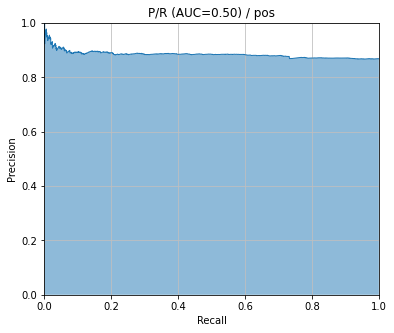

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import classification_report
from matplotlib import pyplot
from matplotlib import pylab
import numpy as np
import time

def plot_pr(auc_score, precision, recall, label=None):
    pylab.figure(num=None, figsize=(6, 5))
    pylab.xlim([0.0, 1.0])
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('Recall')
    pylab.ylabel('Precision')
    pylab.title('P/R (AUC=%0.2f) / %s' % (auc_score, label))
    pylab.fill_between(recall, precision, alpha=0.5)
    pylab.grid(True, linestyle='-', color='0.75')
    pylab.plot(recall, precision, lw=1)
    pylab.show()

start_time = time.time()
# temp = np.c_[index1, index2, index7, index8, f]
temp = np.c_[index1, index2, f]
x = temp[(temp[:, 0] > 0)]
print(len(x))
# print(temp[:10])

average = 0
testNum = 50
for i in range(0, testNum):
#     X_train, X_test, y_train, y_test = train_test_split(x[:, :2], x[:, 3],
#                                                     test_size=0.2)
    X_train, X_test, y_train, y_test = train_test_split(x[:, 1:-1], x[:, -1],
                                                    test_size=0.2)
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    p = np.mean(y_pred == y_test)
    average += p

answer = lr.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, answer)
report = answer > 0.5
print(classification_report(y_test, report, target_names=['neg', 'pos']))
print("average precision:", average / testNum)
print("time spent:", time.time() - start_time)
plot_pr(0.5, precision, recall, "pos")

In [ ]:
a = np.array([[np.nan], [1], [2]])
a = np.append(a, [1, 2, 3])
print(a[:-1])
print(type(a))